In [ ]:
#| default_exp hwc

In [ ]:
#| hide
from nbdev.showdoc import *

In [1]:
#| export
from fastcore.utils import *
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.linalg


Establish a basic class of hot water cylinder that can be used to model a stratified hot water cylinder. The model is based on the following assumptions:


[Model Predictive Control of Heat Pump Water Heaters for Energy Efficiency](https://www.aceee.org/files/proceedings/2014/data/papers/1-296.pdf)

[Dynamic modeling of a sensible thermal energy storage tank with an
immersed coil heat exchanger under three operation modes](https://engineering.purdue.edu/JainResearchLab/pdf/dynamic-modeling-sensible-thermal-energy-storage-immersed-coil-heat-exchanger.pdf)

\section{Nomenclature}

$\Delta \quad$ internal heat transfer scaling parameter

$\dot{m}_{c} \quad$ mass flow rate of IHX coil fluid

$\dot{m}_{c w} \quad$ mass flow rate of inlet domestic cold water

$\dot{m}_{t} \quad$ discharge mass flow rate through tank

$\dot{Q}_{\text {coil }} \quad$ heat transfer rate due to IHX coil

$\dot{Q}_{j+1}$ heat transfer rate between nodes $j$ and $j+1$

$\dot{Q}_{j-1} \quad$ heat transfer rate between nodes $j$ and $j-1$

$\dot{Q}_{\text {wall }}$ heat transfer rate for losses to surroundings

A cross-sectional area of node control volume

$A_{w} \quad$ wall contact surface area

$c_{v} \quad$ specific heat capacity of water

$j \quad$ current node in iterative energy equations

$j+1 \quad$ represents node below node $j$

$\begin{array}{ll}j-1 & \text { represents node above node } j \\ k & \text { internal node interaction heat transfer coefficient } \\ k_{w} & \text { lumped heat transfer coefficient for losses across walls } \\ m & \text { mass of node } \\ s_{1} & \text { discharge fluid correction factor } \\ T & \text { temperature } \\ t & \text { time } \\ T_{c w} & \text { domestic cold water temperature } \\ T_{e n} & \text { IHX coil fluid inlet temperature } \\ T_{e x} & \text { IHX coil fluid outlet temperature } \\ w_{t} & \text { tank wall thickness } \\ z & \text { vertical height variable with respect to tank bottom }\end{array}$

\begin{equation*}
\begin{Bmatrix}
m_1c_v\frac{dT_1}{dt}\\
m_2c_v\frac{dT_2}{dt}\\
m_3c_v\frac{dT_3}{dt}\\
\vdots  \\
m_{n-1}c_v\frac{dT_{n-1}}{dt}\\
m_nc_v\frac{dT_n}{dt}\\

\end{Bmatrix} = 
\begin{bmatrix}
\alpha & \beta & 0 & \cdots & & \\
\gamma & \alpha & \beta & 0 & \cdots &  \\
0 & \gamma & \alpha & \beta & 0 & \cdots &  \\
& &  & \ddots & \\
0 & \cdots & & \gamma & \alpha & \beta  \\
0 & \cdots &   &  & \gamma & \alpha   \\
\end{bmatrix}
\begin{Bmatrix}
T_1\\
T_2\\
T_3\\
\vdots \\
T_{n-1}\\
T_n\\
\end{Bmatrix}
+
\begin{bmatrix}
\zeta \\
\vdots \\
\end{bmatrix}
\dot{m_c}
+
\begin{bmatrix}
\eta & \zeta \\
\vdots  & \vdots \\
\\
0 & 0 \\
\end{bmatrix}
\begin{Bmatrix}
\dot{m_t}\\
T_0
\end{Bmatrix}
\end{equation*}

\begin{aligned}
& \alpha=-\left(\frac{k_{j-1} A}{\Delta z_j}+\frac{k_{j+1} A}{\Delta z_j}+\frac{k_w A_w}{w_t}\right), \quad \\
&\beta=\frac{k_{j+1} A}{\Delta z_j}, \quad \\
&\gamma=\frac{k_{j-1} A}{\Delta z_j}, \\
& \delta=\frac{k_w A_w}{w_t}, \quad\\
&\zeta=c_v\left(T_{\text {in. } j}-T_{\text {out } . j}\right), \quad \\
&\eta=s_1 c_v\left(T_{j+1}-T_j\right) \\
\end{aligned}

In [2]:
hwc = HWC()

NameError: name 'HWC' is not defined

In [3]:
hwc.temperatures

NameError: name 'hwc' is not defined

In [19]:
#| export
class HWC():
  """
  Model of a Hot Water Cylinder using a nodal approach.
  """
  def __init__(self,
              element = 3,        # kW
              T_set = 75,         # °C
              T_deadband = 2,     # °C
              radius =.25,        # m
              height = 1.1,       # m
              nodes = 7,
              delta = 50):
    super(HWC, self).__init__()
    self.U = 0.8/60 # heat transfer coefficient 0.5 kJ/s m2K x 1/60 min/s [0.5 kJ/min m2K Jack Paper]
    self.nodes = nodes
    self.Cp = 4.184 #kJ/kgK
    self.rho = 1000 #kg/m3
    self.delta = delta
    self.T_ambient = 15 #  Air temperature that the cylinder located in °C
    self.T_cold = 15 # Make up water temperature °C
    self.T_demand = 45 #T_demand - temperature of the end use (shower)  °C
    self.T_deadband = T_deadband #T_deadband  - thermostat deadband °C
    self.T_set = T_set #T_set - thermostat set point °C
    self.element = element # kW = kJ/s
    self.radius = radius
    self.height = height
    self.alpha = 0.01
    self.T_set_bu = 60
    temperature = self.T_set + np.random.uniform(-4, 0)
    self.temperatures = np.linspace(temperature+.4,temperature-.4,self.nodes)
    self.thermostat = np.array([0,0]) # bulk / nodal high / nodal low
    self._thermostat()
  @property
  def surface_area(self): return 2* np.pi * self.radius * self.height + 2 * np.pi * self.radius**2 # m2

  @property
  def volume(self): return np.pi * self.radius ** 2 * self.height  # m3

  @property
  def heat_capacity(self): return self.Cp*self.rho*self.volume # kJ/K

  @property
  def x_section_area(self): return np.pi * self.radius**2 # m2 NODAL APPROACH

  @property
  def cylinder_wall_area(self): return 2* np.pi * self.radius * self.height  # m2 NODAL APPROACH

  @property
  def z(self): return self.height / self.nodes # m2 NODAL APPROACH

  @property
  def uas(self): 
    uas = np.ones((self.nodes)) * self.U * self.cylinder_wall_area / self.nodes
    uas[0]  += self.U * self.x_section_area               # Add end heat losses
    uas[-1] += self.U * self.x_section_area               # Add end heat losses
    return uas #  NODAL APPROACH

  @property
  def nj(self): return self.Cp * self.volume * self.rho / self.nodes # m2 NODAL APPROACH

  @property
  def K(self): return 1                                         # [kJ/(sec C)] = 7.084 kJ/hr-C

  @property
  def s1(self): return .92                                         # [kJ/(sec C)] = 7.084 kJ/hr-C

  @property
  def Δ(self):  return self.delta                                        # Dimensionless factor


Provide a mechanisim to set the thermostat state based on the model temperature

In [27]:
#| export
@patch
def _update_model(self:HWC, action = None, flow = None, timestep_sec=60):
    k = self._temperature_inversion()  # check for temperature inversion and update the conductivity to correct
    Ac = np.identity(self.nodes)
    for j in range(1,self.nodes-1):
        Ac[j][j] =  -(k[j-1] * self.x_section_area / (self.z) + k[j+1] * self.x_section_area / (self.z) +  self.uas[j]/timestep_sec) 
    Ac[0][0] =    -(k[1] * self.x_section_area / (self.z)+ self.uas[0]/timestep_sec)
    Ac[-1][-1] =  -(k[-2] * self.x_section_area / (self.z) + self.uas[-1]/timestep_sec)

    for j in range(self.nodes-1):
        Ac[j][j+1] = k[j+1] * self.x_section_area / (self.z) # β beta is from node below

    for j in range(1,self.nodes):
        Ac[j][j-1] = k[j-1] * self.x_section_area / (self.z)   # γ gamma is from node below

    '''
    create continuous state space matrix Bc
    Bc = [bottom_element, flow, wall_losses, ]
    '''
    Bc= np.zeros((self.nodes,4))
    # Bc[int(.3*self.nodes)-1 ,0]  = 0.6 * 0 #self.top_element    # put upper element at node 30% from the top
    # Bc[int(.3*self.nodes)   ,0]  = 0.4 * 0 #self.top_element     # put lower element at node 30% from the top
    
    Bc[self.nodes-2 , 1]  = 0.6 *self.element     # put lower element at node 80% from the top
    Bc[self.nodes-1 , 1]  = 0.4 *self.element      # put lower element at node 80% from the top
    
    for j in range(0,self.nodes-1):
        Bc[j,2] = self.s1 * self.Cp * self.rho * min(0,(self.temperatures[j+1] - self.temperatures[j]))
    Bc[-1,2] =  self.s1 * self.Cp * self.rho * min(0,(self.T_cold - self.temperatures[-1]))

    Bc[:,3] = self.uas   # Energy flow as heat loss to the room

    Ac = Ac* timestep_sec/self.nj
    Bc = Bc* timestep_sec/self.nj

    #create discrete-time state-space system: 
    n, nb = Ac.shape[1], Bc.shape[1]
    v = np.vstack((np.hstack((Ac,Bc)),np.zeros((nb,nb+n))))
    s = scipy.linalg.expm(v)

    u = [0, action, flow, 15]
    phi, gamma = s[0:n,0:n], s[0:n,n:n+nb]
    self.temperatures =  np.dot(phi,self.temperatures) + np.dot(gamma, u)
    return 
    
@patch
def _temperature_inversion(self:HWC):
    k = np.ones(self.nodes)*self.K
    # make delta variable based on the level of mixiness of the tank
    # Δ = 1 if (self.control_variables[0] >.1 or self.control_variables[1] >.1) else self.Δ
    Δ = self.Δ 
    k[1] = k[1] * Δ * abs(self.temperatures[0] - self.temperatures[1]) if self.temperatures[0] < self.temperatures[1] else k[1] # if top node is colder than node below
    for j in range(1,self.nodes-1):
        k[j+1] = k[j+1] * Δ * abs(self.temperatures[j] - self.temperatures[j+1]) if self.temperatures[j] < self.temperatures[j+1] else k[j+1] # if node is colder than node below (pushes temperature down)
        k[j-1] = k[j-1] * Δ * abs(self.temperatures[j] - self.temperatures[j-1]) if self.temperatures[j] > self.temperatures[j-1] else k[j-1] # if node is hotter than node above
    k[-2] = k[-2] * Δ *abs(self.temperatures[-1] - self.temperatures[-2]) if self.temperatures[-1] > self.temperatures[-2] else k[-2] # if bottom node is hotter than node above
    return k

In [28]:
#| export
@patch
def _thermostat(self:HWC):
    "Thermostat state change"
    # Nodal cylinder thermostat
    self.thermostat[0] = 0 if self.temperatures[self.nodes-2] > self.T_set else self.thermostat[0] # Turn off if T > T_set
    self.thermostat[0] = 1 if self.temperatures[self.nodes-2] < self.T_set- self.T_deadband else self.thermostat[0] # Turn on the element
    # Nodal cylinder thermostat
    self.thermostat[1] = 0 if self.temperatures[self.nodes-2] > self.T_set_bu else self.thermostat[1] # Turn off if T > T_set
    self.thermostat[1] = 1 if self.temperatures[self.nodes-2] < self.T_set_bu- self.T_deadband else self.thermostat[1] # Turn on the element
    return self.thermostat

Update the model temperature based on the thermostat state / flow / heat loss

$T_{i+1} = T_i + \frac{F_i}{V}[T_{in} - T_i]\Delta{t}+\frac{Q_i}{C_v\rho V}\Delta{t}-\frac{UA}{C_v\rho V}[T_i-T_{atm}]\Delta{t}$


Text(0.5, 0.98, 'dd')

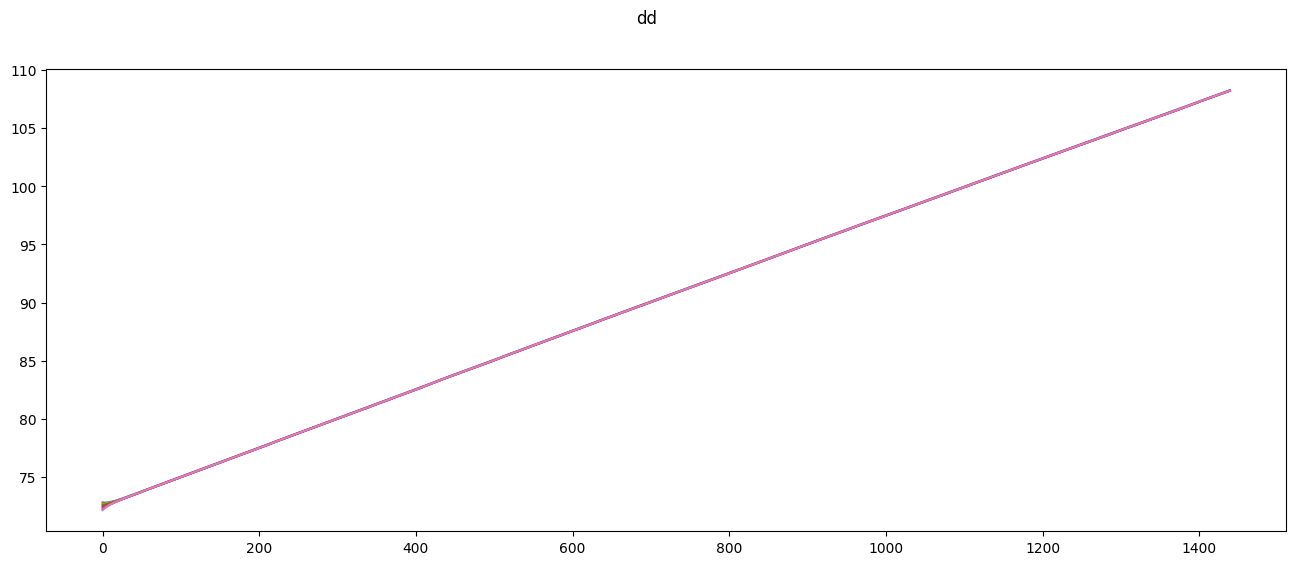

In [29]:
env = HWC(T_set=75, element=3, delta=5000)
temp = []
for i in range(60*24):
    env._update_model(action = 0, flow = 0)
    temp.append(env.temperatures)
    # print(env.temperatures.mean(),env.thermostat, env.temperatures[0]-env.temperatures[-1],env.temperature )
# fig, ax = plt.subplots(figsize=(20,10))
# ax.plot(env._temps.reshape(-1,env.nodes))
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(np.vstack(temp))
fig.suptitle('dd')

Text(0.5, 0.98, 'dd')

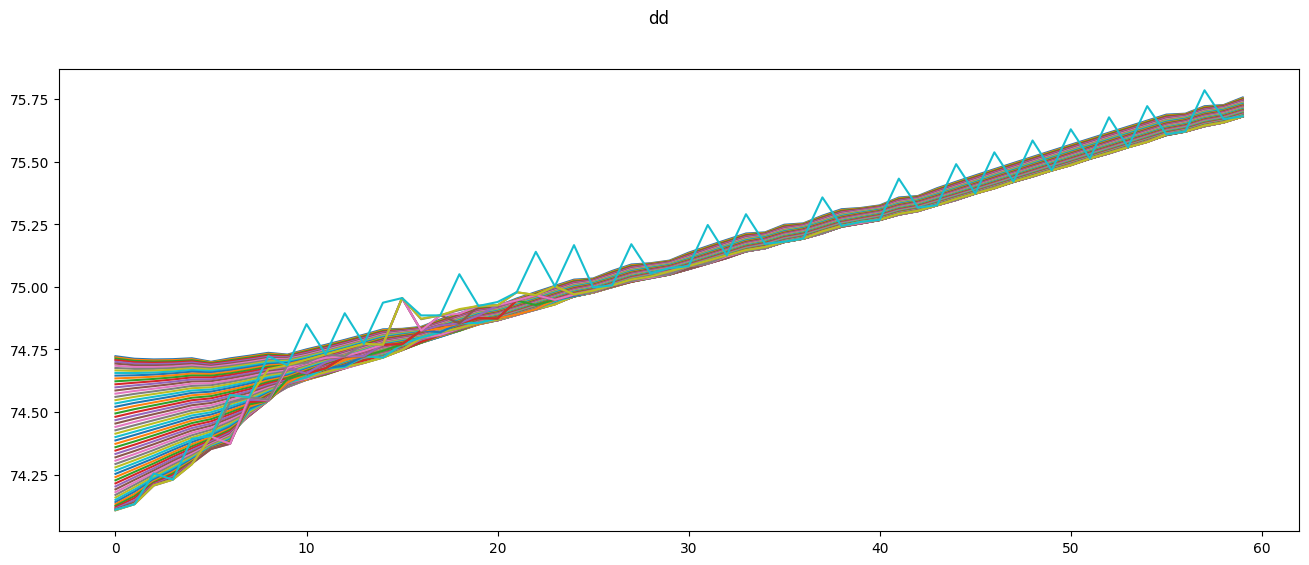

In [32]:
env = HWC(T_set=75, element=3, delta=100000,nodes=60)
temp = []
for i in range(60):
    env._thermostat()
    # print(env.thermostat)
    action = np.random.choice([0,0,0,1])
    if action:
        for j in range(6):
            env._update_model(action = action * env.thermostat[0] , flow = 0, timestep_sec=10)
    else:
        env._update_model(action = action * env.thermostat[0] , flow = 0)
    temp.append(env.temperatures)
    # print(env.temperatures.mean(),env.thermostat, env.temperatures[0]-env.temperatures[-1],env.temperature )
# fig, ax = plt.subplots(figsize=(20,10))
# ax.plot(env._temps.reshape(-1,env.nodes))
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(np.vstack(temp))
fig.suptitle('dd')

In [11]:
env = HWC(T_set=75, element=3, delta=100000)
env.temperatures

array([75.15892857, 75.02559524, 74.8922619 , 74.75892857, 74.62559524,
       74.4922619 , 74.35892857])

Text(0.5, 0.98, 'dd')

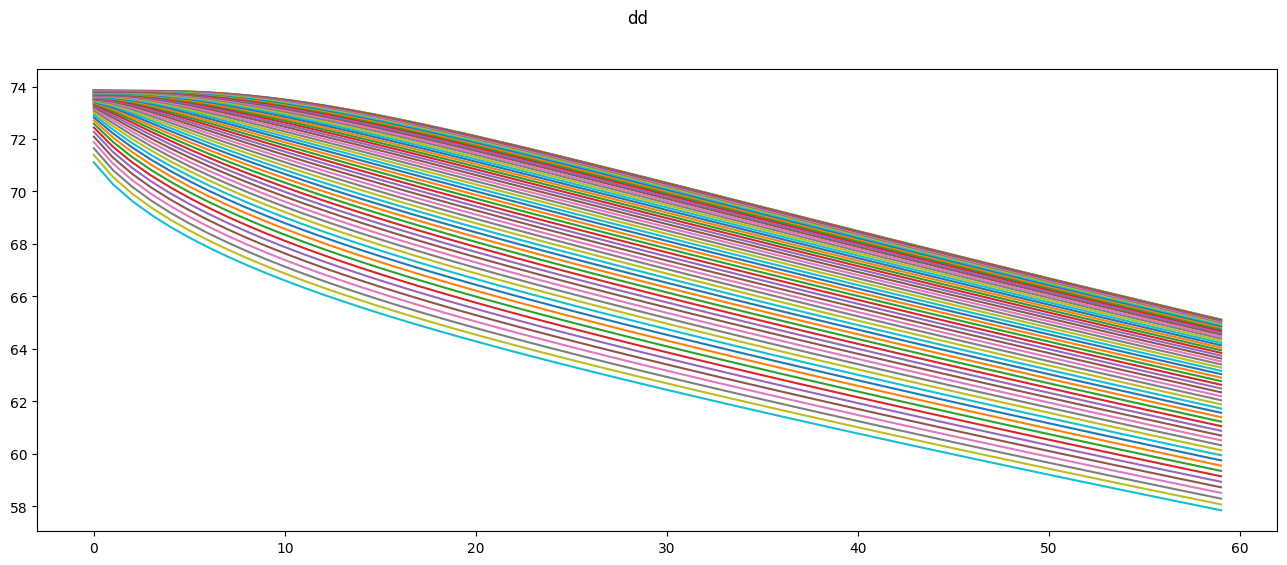

In [18]:

out = .05 / 2 / 30 / 60
env = HWC(T_set=75, element=3, delta=100000, nodes=60)
temp = []
for i in range(60):
    env._thermostat()
    # print(env.thermostat)
    action = 0

    env._update_model(action = action , flow = out)
    temp.append(env.temperatures)
    # print(env.temperatures.mean(),env.thermostat, env.temperatures[0]-env.temperatures[-1],env.temperature )
# fig, ax = plt.subplots(figsize=(20,10))
# ax.plot(env._temps.reshape(-1,env.nodes))
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(np.vstack(temp))
fig.suptitle('dd')


Provide some initialisation functions to set the model up with some default values

In [5]:
#| export
@patch
def reset(self:HWC):
    self.T = self.T_set + np.random.uniform(-4, 0)
    self.thermostat = 0
    multiplier = 2 if self.bedrooms is None else self.bedrooms
    self.thermogram = np.ones([7,24])*(.5+multiplier*.1)

In [6]:
df = (pd.DataFrame(load_demand(path = Path('../data/drawprofiles'),bed=5,unit=4)))
df.columns=["flow"]
df = df.merge(load_power(path = Path('../data')), how='left', left_index=True, right_index=True)
df.head()

,flow,price,price_kw,date,week,hour,day,peak,tou,cost,n_cost,sr_cost,lr_cost
timestamp,,,,,,,,,,,,,
2020-01-01 00:00:00,0.0,7.920,0.007920,2020-01-01,1,0,2,0,0.02,0.027920,-0.22080,0.162438,0.149272
2020-01-01 00:01:00,0.0,8.526,0.008526,2020-01-01,1,0,2,0,0.02,0.028526,-0.21474,0.158675,0.145694
2020-01-01 00:02:00,0.0,9.132,0.009132,2020-01-01,1,0,2,0,0.02,0.029132,-0.20868,0.155010,0.142235
2020-01-01 00:03:00,0.0,9.738,0.009738,2020-01-01,1,0,2,0,0.02,0.029738,-0.20262,0.151437,0.138888
2020-01-01 00:04:00,0.0,10.344,0.010344,2020-01-01,1,0,2,0,0.02,0.030344,-0.19656,0.147952,0.135645


In [ ]:
hwc = HWC(T_set=55, T_deadband=2, element=3000, radius=.2, height=1.5)
results = []
for index, row in df.loc['2020-01-01'].iterrows():
  raw_flow = 0
  hwc.flow = raw_flow*(hwc.T_demand-hwc.T_cold)/(hwc.T-hwc.T_cold)
  hwc._thermostat()
  hwc.T = hwc._update_temperatures(action=0)
  results.append([index,hwc.T, hwc.thermostat, hwc.flow,row.cost])
results = pd.DataFrame(results, columns=['time','temperature','thermostat','flow','cost']).set_index('time')

In [ ]:
print(f'The HWC volume is {int(hwc.volume*1000)} liters')
print(f'The HWC surface area is {hwc.surface_area:.2f} m2')
print(f'One day standing heat losses  : {4.128*.188*(results.temperature.max()-results.temperature.min()):.2f} kWh')

The HWC volume is 188 liters
The HWC surface area is 2.14 m2
One day standing heat losses  : 1.42 kWh


The standing heat loss for a tank should be in the order of 1.7 kWh / day for a tank at 55 degrees.

Guidance for loss is 3 W/K for a tank at 55 degrees

https://sustainableengineering.co.nz/portfolio-item/dhw-tanks-w-k-from-kwh-day/

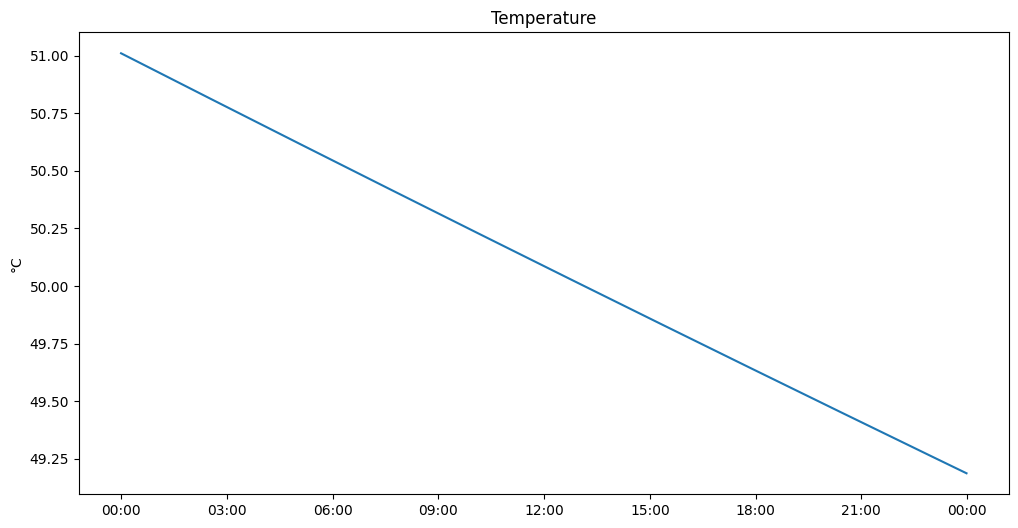

In [ ]:
fig, ax = plt.subplots(nrows=1, figsize=(12,6), sharex=True)
ax.plot(results.temperature)
ax.set_ylabel('°C')
ax.set_title('Temperature')
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M"))

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()